In [40]:
!pip install transformers --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Imports

In [41]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
from transformers import pipeline, AutoImageProcessor, AutoModelForDepthEstimation

# Model

In [42]:
class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

# Depth Estimation Model Instances

In [43]:
# When inferring model through pipeline
pipe_small = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
pipe_large = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-large-hf")

# When inferring model Manually
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# Step1: Extract Object Boundary Contours

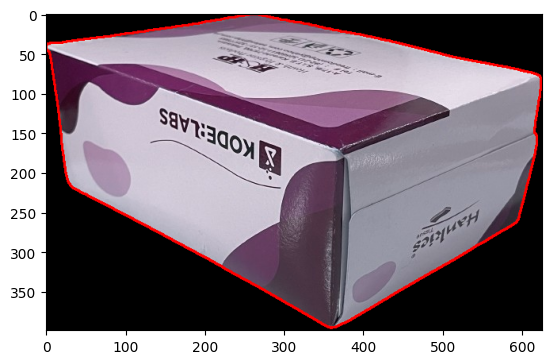

In [44]:
# Read Image RGB Image
rgb_image = cv2.imread("/kaggle/input/key-images/tissue_box_trans.png")
rgb_image_copy = rgb_image.copy()

# Convert it into gray-scale
imgray = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

# Find top contour
contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(rgb_image_copy, contours, -1, (255, 0, 0), 2)

# Show contour
plt.imshow(rgb_image_copy)

In [45]:
# Make point objects
contour_points = []

for contour in contours:
    for point in contour:
        x,y = point[0]
        contour_points.append(Point(x,y,0))

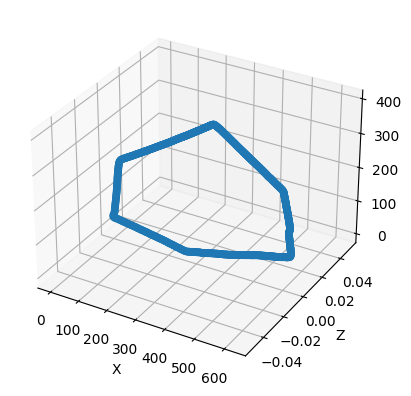

In [46]:
# Extract coordinates for plotting
x_vals = [point.x for point in contour_points]
y_vals = [point.y for point in contour_points]
z_vals = [point.z for point in contour_points]


# Plot the points in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_vals, z_vals, y_vals)

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

# ax.invert_zaxis()

plt.show()

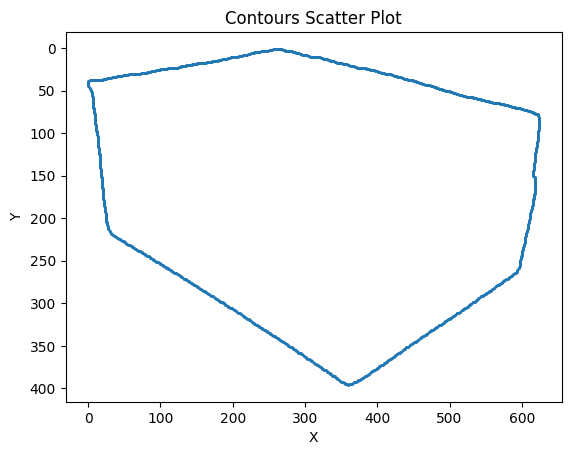

In [47]:
# Create a new figure
plt.figure()

x_vals = [point.x for point in contour_points]
y_vals = [point.y for point in contour_points]

plt.scatter(x_vals, y_vals, s=1)

# Set plot title and labels
plt.title("Contours Scatter Plot")
plt.xlabel("X")
plt.ylabel("Y")

# Invert y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

# Step2: Find Object Depth

(626, 399)


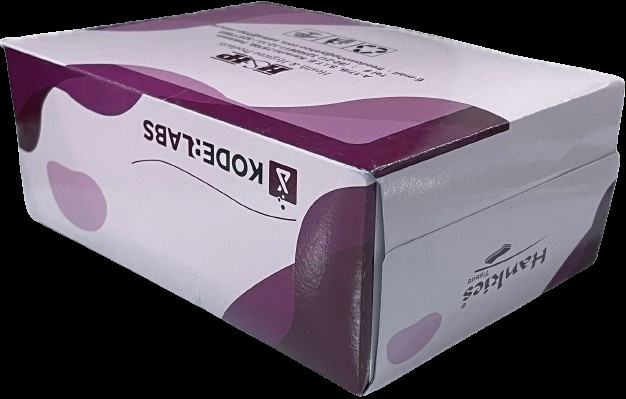

In [48]:
image = Image.fromarray(rgb_image)
print(image.size)
image

In [49]:
# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [50]:
h, w = image.size[::-1]

depth = torch.nn.functional.interpolate(predicted_depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]

raw_depth = Image.fromarray(depth.cpu().numpy().astype('uint16'))
raw_depth.save("predicted_depth.png")

depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
depth = depth.cpu().numpy().astype(np.uint8)
colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

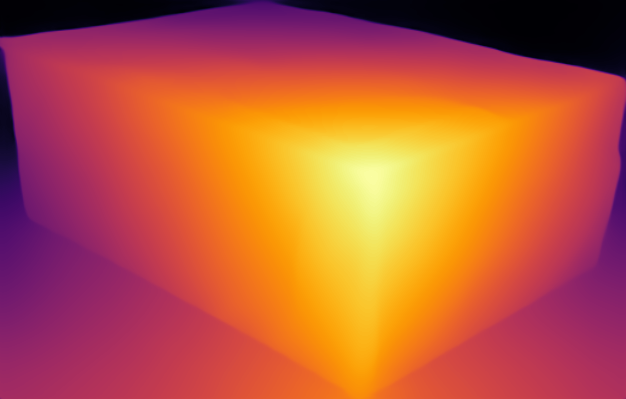

In [51]:
Image.fromarray(colored_depth)

# Step3: Adding z-axis values of each point using the depth values

In [52]:
# Build mesh with 3-D Points

mesh_points = []
boundary = contours[0]
depth_map = prediction[0][0]
dimensions = depth_map.shape

step = 4 # To make the mesh less dense

for y in range(0, dimensions[0], step):
    for x in range(0, dimensions[1], step):
        if cv2.pointPolygonTest(boundary, (x, y), False) >= 0:
            mesh_points.append([x, y, depth_map[y][x]])

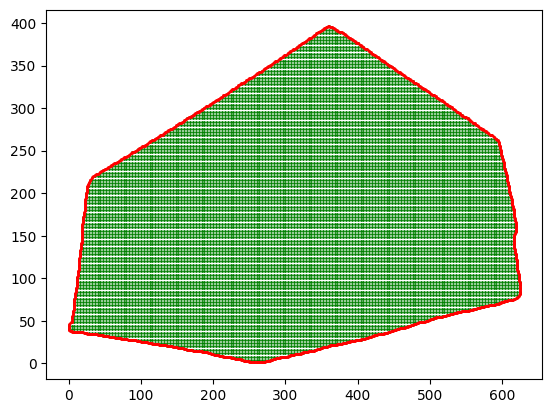

In [53]:
# Plotting mesh without depth

factor = 100 # Enhancing the depth to make it clearer

x_vals = [point[0] for point in mesh_points]
y_vals = [point[1] for point in mesh_points]
z_vals = [point[2] for point in mesh_points]

x_bounds = [point[0][0] for point in boundary]
y_bounds = [point[0][1] for point in boundary]
z_bounds = [0 for point in boundary]

plt.scatter(x_vals, y_vals, s=1, color='green')
plt.scatter(x_bounds, y_bounds, s=1, color='red')

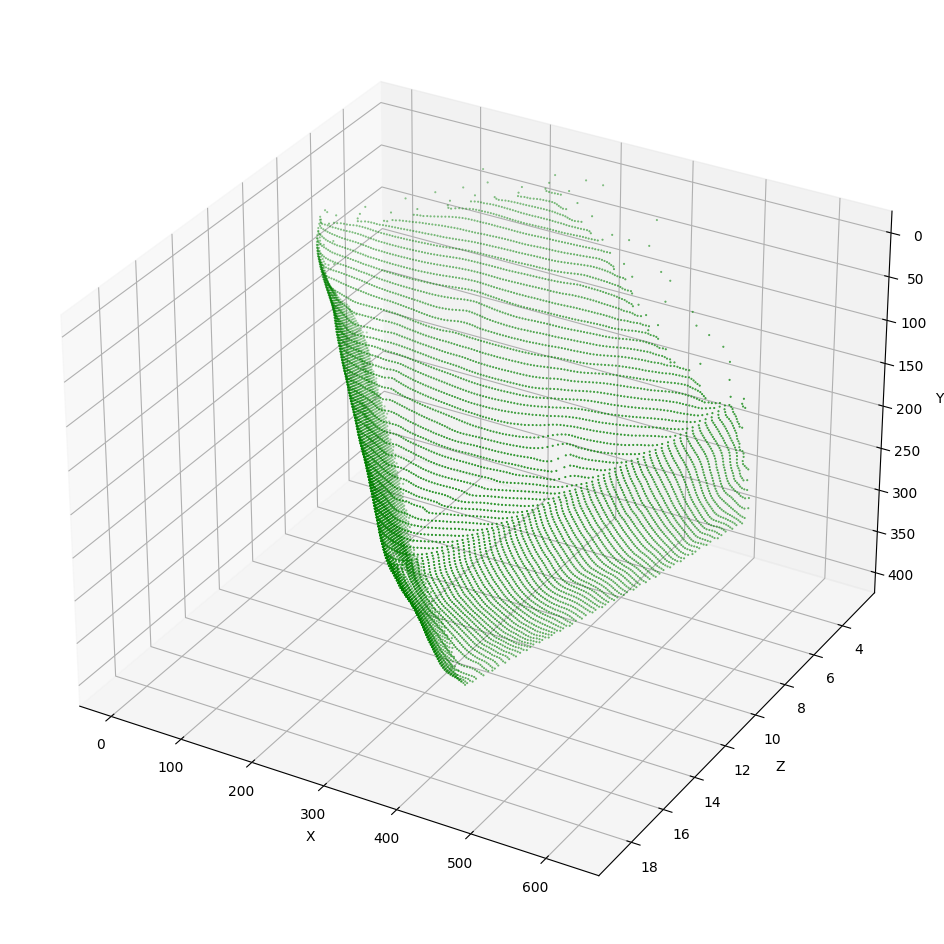

In [54]:
# Plot the points in a 3D scatter plot
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_vals, z_vals, y_vals, s=0.25, color='green')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax.invert_yaxis()
ax.invert_zaxis()

plt.show()

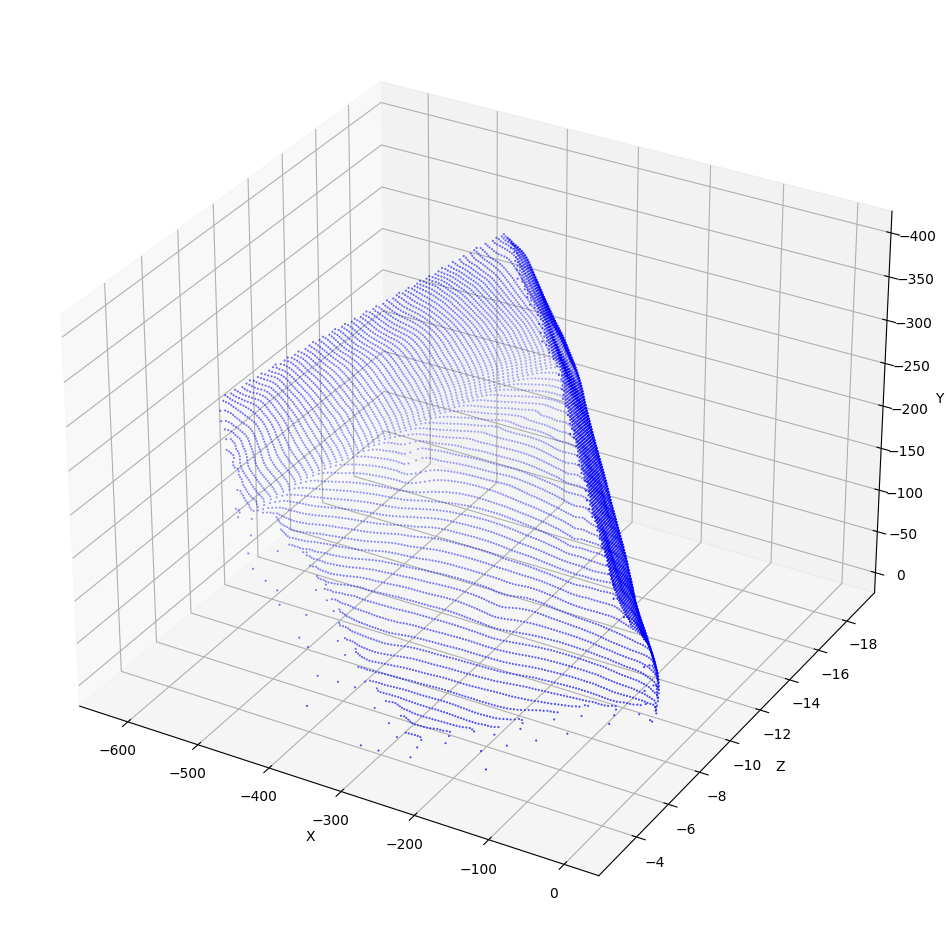

In [55]:
def mirror_points(points):
    return [-p for p in points]

# Plot the points in a 3D scatter plot
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

x_flip = mirror_points(x_vals)
y_flip = mirror_points(y_vals)
z_flip = mirror_points(z_vals)

ax.scatter(x_flip, z_flip, y_flip, s=0.25, color='blue')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax.invert_yaxis()
ax.invert_zaxis()

plt.show()

In [56]:
diff = max(x_vals) - max(x_flip)
x_flip = translate_points(x_flip, diff)

diff = max(y_vals) - max(y_flip)
y_flip = translate_points(y_flip, diff)

diff = max(z_vals) - max(z_flip)
z_flip = translate_points(z_flip, diff)

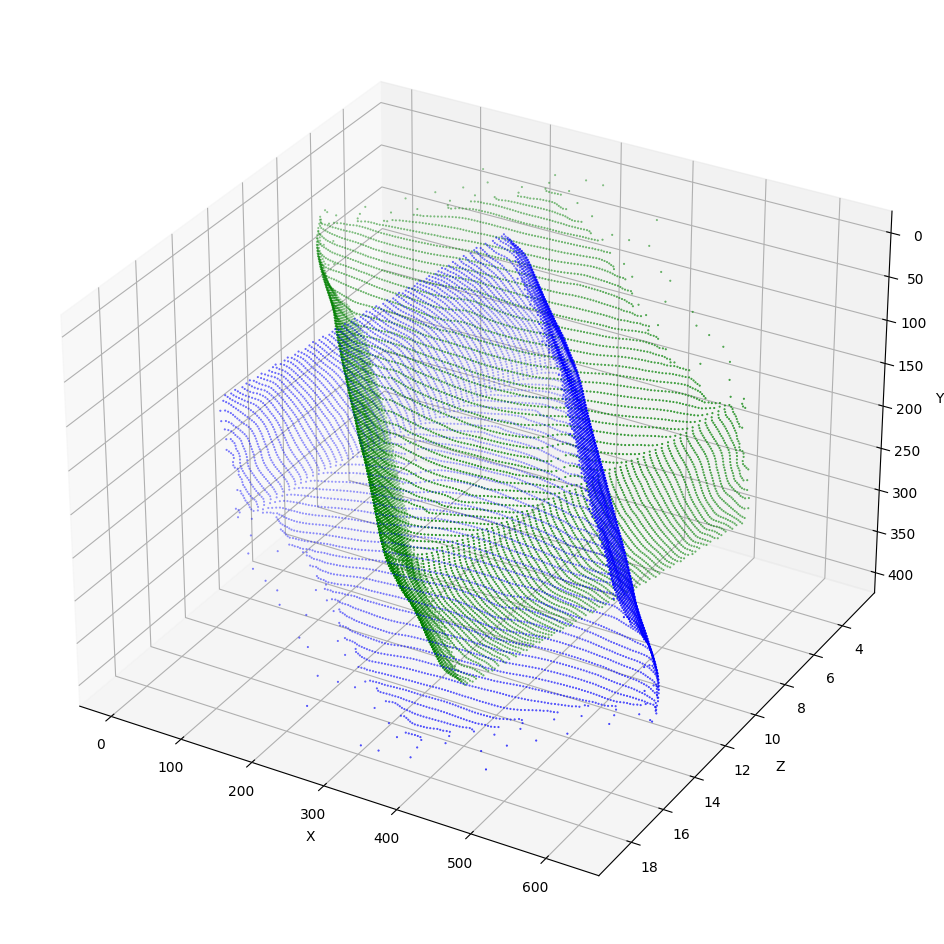

In [57]:
def translate_points(points, offset):
    return [p + offset for p in points]

# Plot the points in a 3D scatter plot
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_vals, z_vals, y_vals, s=0.25, color='green')
ax.scatter(x_flip, z_flip, y_flip, s=0.25, color='blue')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax.invert_yaxis()
ax.invert_zaxis()

plt.show()

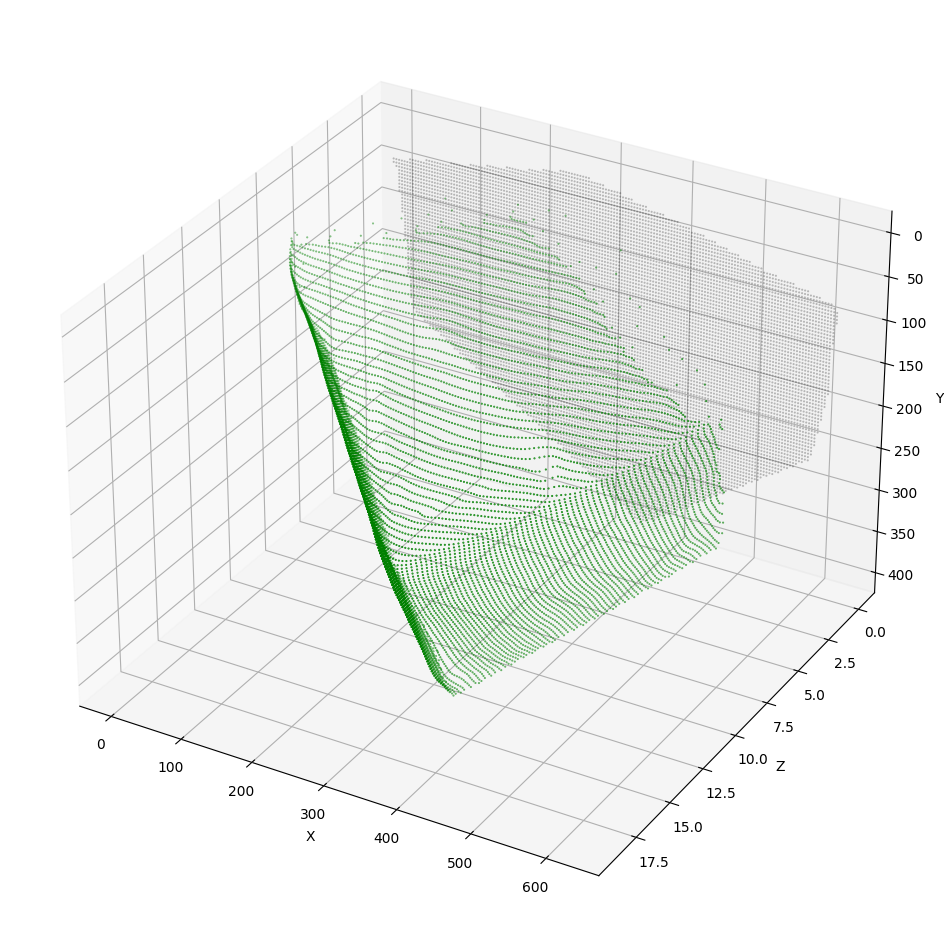

In [58]:
# Plot the points in a 3D scatter plot
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

x_flat = [0 for point in mesh_points]
y_flat = [0 for point in mesh_points]
z_flat = [0 for point in mesh_points]

# Shadows
# ax.scatter(x_flat, z_vals, y_vals, s=0.25, color='black', alpha=0.25)
# ax.scatter(x_vals, z_vals, y_flat, s=0.25, color='black', alpha=0.25)
ax.scatter(x_vals, z_flat, y_vals, s=0.25, color='black', alpha=0.25)

# Surface Mesh
ax.scatter(x_vals, z_vals, y_vals, s=0.25, color='green')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax.invert_yaxis()
ax.invert_zaxis()

plt.show()